In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
from lfw_dataset import fetch_lfw_dataset

In [3]:
plt.rcParams.update({'axes.titlesize': 'small'})

#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
data,attrs = fetch_lfw_dataset(use_raw = True, dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

In [5]:
#print random image
# plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent


The only problem is: how can we tell well-generated faces from bad?

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [43]:
CODE_SIZE = 256
mdl_path = 'saved_models/'

def build_gen():
  temp_gen = Sequential()
  temp_gen.add(L.InputLayer([CODE_SIZE], name='noise'))
  temp_gen.add(L.Dense(10*8*8, activation='elu', name='gen_dense'))

  temp_gen.add(L.Reshape((8,8,10)))
  temp_gen.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu', name='gen_conv0'))
  temp_gen.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu', name='gen_conv1'))
  temp_gen.add(L.UpSampling2D(size=(2,2), name='gen_upsampl'))
  temp_gen.add(L.BatchNormalization())
  temp_gen.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu', name='gen_conv2'))
  temp_gen.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu', name='gen_conv3'))
  temp_gen.add(L.BatchNormalization())
  temp_gen.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu', name='gen_conv4'))
  temp_gen.add(L.Conv2D(3, kernel_size=3, activation='sigmoid', name='gen_outp'))
  return temp_gen

generator = build_gen()
#if 'gen_weights11000.h5' in os.listdir(mdl_path):
generator.load_weights(mdl_path+'gen_weights14100.h5')

In [44]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

In [45]:
def build_disc():
  temp_disc = Sequential()
  temp_disc.add(L.InputLayer(IMG_SHAPE, name='disc_inp'))
  temp_disc.add(L.Conv2D(64, kernel_size=3, activation='elu', name='disc_conv0'))
  temp_disc.add(L.Conv2D(64, kernel_size=3, activation='elu', name='disc_conv1'))
  temp_disc.add(L.BatchNormalization())
  temp_disc.add(L.Conv2D(64, kernel_size=3, activation='elu', name='disc_conv2'))
  temp_disc.add(L.Conv2D(64, kernel_size=3, activation='elu', name='disc_conv3'))
  temp_disc.add(L.Conv2D(64, kernel_size=3, activation='elu', name='disc_conv4'))
  temp_disc.add(L.BatchNormalization())
  temp_disc.add(L.Conv2D(128, kernel_size=5, strides=2, activation='elu', name='disc_conv5'))
  temp_disc.add(L.Conv2D(3, kernel_size=3, strides=1, activation='elu', name='disc_conv6'))
  temp_disc.add(L.Flatten())
  temp_disc.add(L.Dense(256,activation='elu', name='disc_dense'))
  temp_disc.add(L.Dense(2, activation=tf.nn.log_softmax, name='disc_outp'))
  return temp_disc

discriminator = build_disc()
#if 'disc_weights11000.h5' in os.listdir(mdl_path):
discriminator.load_weights(mdl_path+'disc_weights14100.h5')

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* You can find useful tricks here https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [11]:
import matplotlib.pyplot as plt

def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs] # + np.random.normal(0, 0.05, size=(bsize, 36, 36, 3))

def sample_images(nrow, ncol, sharp=False, g1=0):
    images = g1.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize, g1):
    plt.figure(figsize=(3,2))
    #print('disc =', discriminator(sample_data_batch(bsize)))
    #print(np.exp(discriminator(sample_data_batch(bsize))[:,1]))
    plt.hist(np.exp(discriminator(sample_data_batch(bsize))[:,1]),
             label='D(x)', alpha=0.5, bins=30)
    plt.hist(np.exp(discriminator.predict(g1(sample_noise_batch(bsize)))[:,0]),
             label='D(G(z))',alpha=0.5, bins=30)
    plt.title('Generated vs real data')
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [46]:
disc_optimizer = tf.optimizers.SGD(6e-4)
gen_optimizer = tf.optimizers.SGD(5e-4)

In [ ]:
from IPython import display
from tqdm import tnrange

btch_sze = 256

for epoch in tnrange(13921, 50001):
  d_loss = 0
  tp = 0

  ########################
  #discriminator training#
  ########################
  acc=0
  while acc < 0.75:
    real_data = sample_data_batch(btch_sze)
    noise = sample_noise_batch(btch_sze)
    real_data += np.random.normal(0, 0.05, real_data.shape)
    noise += np.random.normal(0, 0.05, noise.shape)

    with tf.GradientTape() as tp:
      logp_real = discriminator(real_data)

      generated_data = generator(noise)

      logp_gen = discriminator(generated_data)

      d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 0])
      acc = 0.8*acc + (np.mean(np.exp(logp_real[:, 1])>0.5) + np.mean(np.exp(logp_gen[:, 0])>0.5))/2
      acc /= 1.8

      #regularize
      d_loss += 0.02 * tf.reduce_mean(discriminator.layers[-1].kernel**2)

    #optimize
    disc_optimizer.minimize(d_loss, var_list=discriminator.trainable_weights, tape=tp)

  ########################
  ###generator training###
  ########################
  
  cnt_steps=0
  while acc > 0.35 or cnt_steps<1:
    cnt_steps+=1
    noise = sample_noise_batch(btch_sze)

    with tf.GradientTape() as tp1:

      generated_data = generator(noise)
      logp_gen = discriminator(generated_data)

      g_loss = -tf.reduce_mean(logp_gen[:, 1])
      acc = 0.8*acc + np.mean(np.exp(logp_gen[:, 0])>0.5)
      acc /= 1.8

    #optimize
    gen_optimizer.minimize(g_loss, var_list=generator.trainable_variables, tape=tp1)

  if epoch % 300==0:
    generator.save_weights(mdl_path+f'gen_weights{epoch}.h5')
    discriminator.save_weights(mdl_path+f'disc_weights{epoch}.h5')

  if epoch % 20==0:
    #display.clear_output(wait=True)
    sample_images(2,3,True, generator)
    sample_probas(100, generator)

epoch.................batch size

1000-4000 .............. 32 & lr=1e-3

4001-5000 .............. 64

5001-8000 .............. 128

8001-11000 ............. 256

11000-12000 ........... 256 & added image noise for discriminator

12001-12900 ........... 256 & gen_lr=5e-4

12901-13500 ........... 256 & disc_lr=8e-4

13501-14100 ........... 256 & disc_lr=6e-4

If you reduce lr too quickly the models will overfit.

4/4 [==============================] - 0s 5ms/step


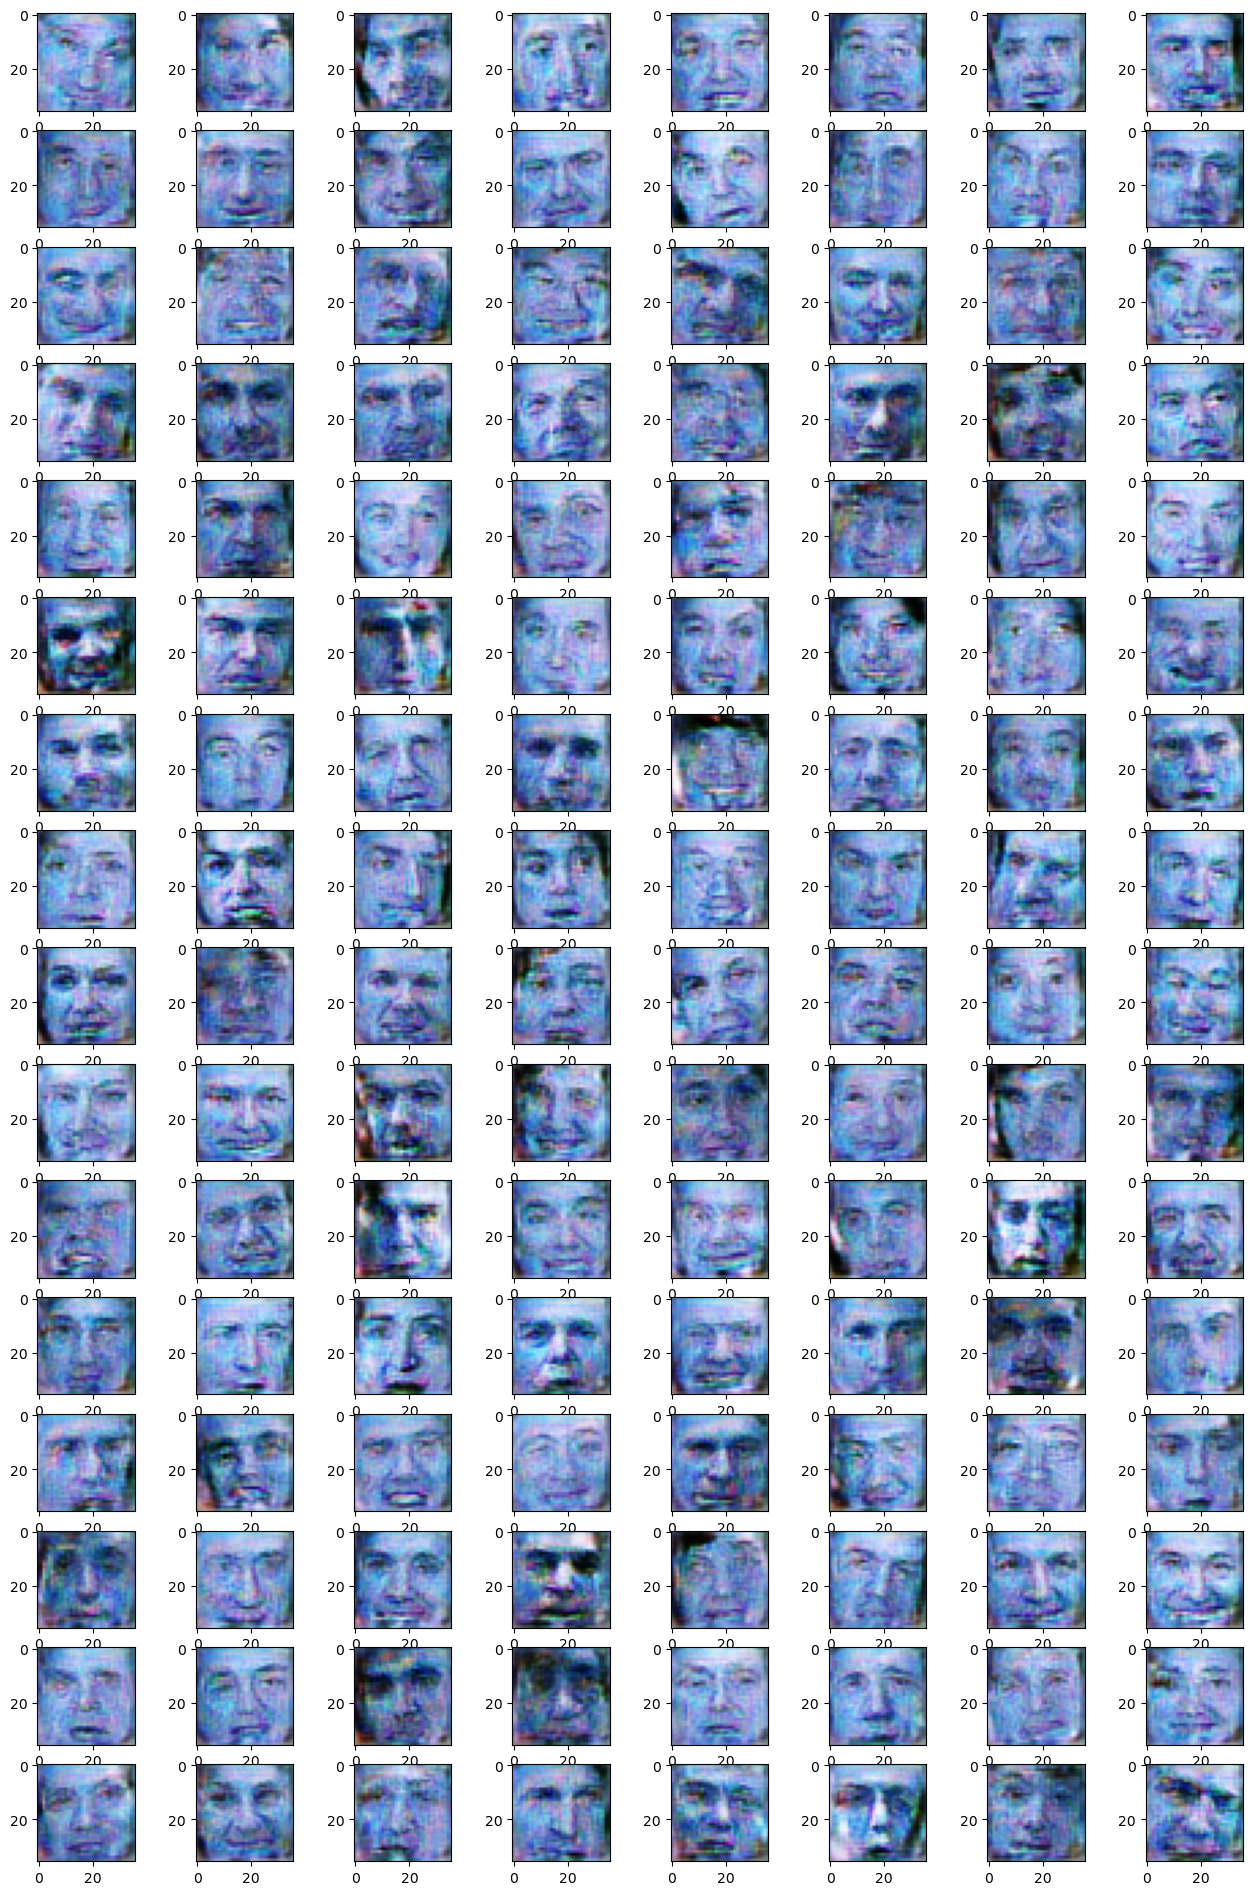

In [49]:
# this was outputed on epoch 14100

import numpy as np
g2 = build_gen()
g2.load_weights(mdl_path+'gen_weights14100.h5')

IMG_SHAPE=(36,36,3)
plt.figure(figsize=[16,24])
sample_images(16, 8, g1=g2)

4/4 [==============================] - 0s 49ms/step


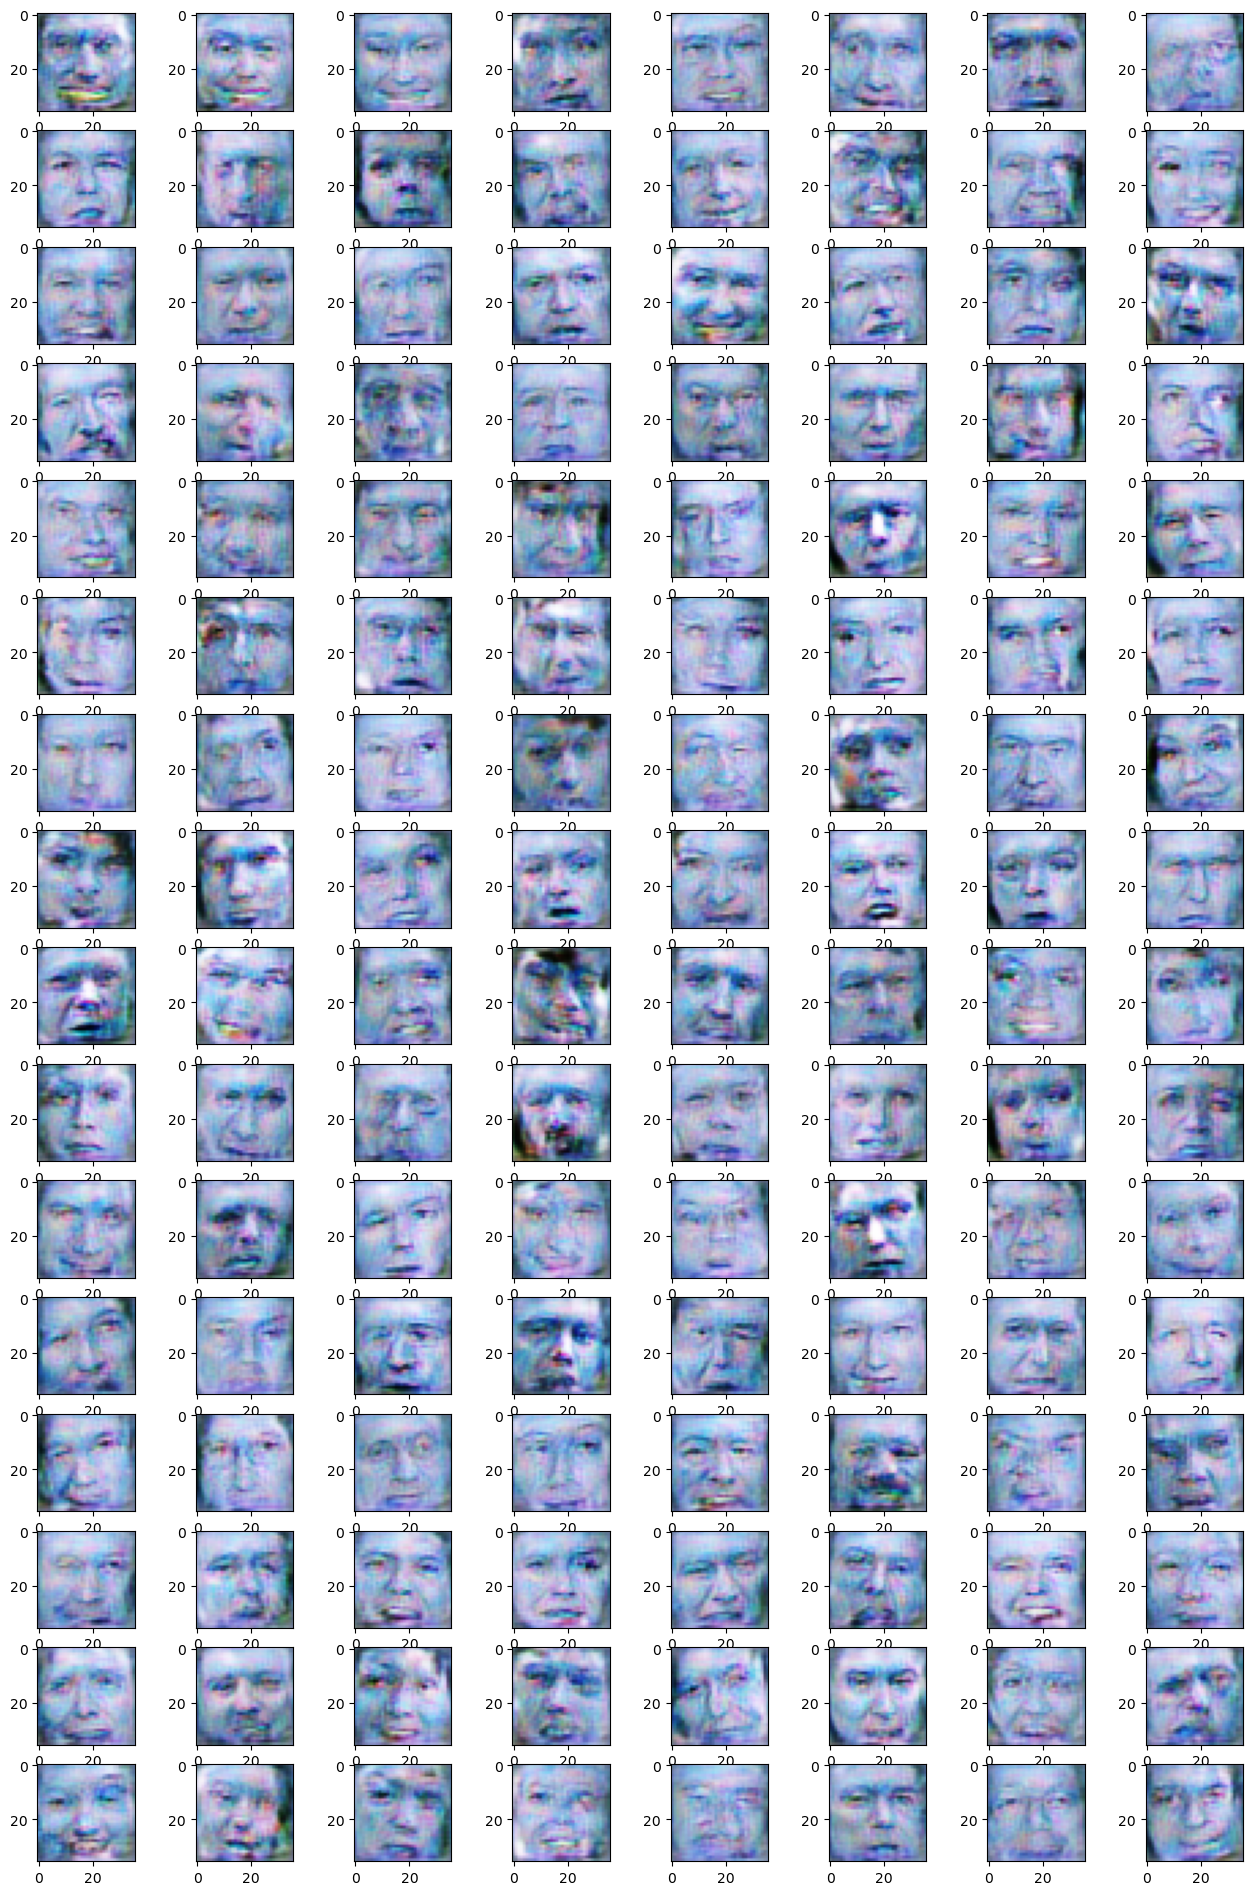

In [42]:
# this was outputed on epoch 12600

import numpy as np
g2 = build_gen()
g2.load_weights(mdl_path+'gen_weights11000.h5')

IMG_SHAPE=(36,36,3)
plt.figure(figsize=[16,24])
sample_images(16, 8, g1=g2)